In [43]:
import pandas as pd
import numpy as np
from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [44]:
#Загрузка файла
df = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FPMcY4_9kTUpNg', sep = ';')

In [45]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [46]:
df.shape

(1000, 3)

In [47]:
#Конвертируем тип данных колонки value
df['value']=pd.to_numeric(df['value'].str.replace(',', '.'), errors='coerce')

In [48]:
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [49]:
#Определим контрольную группу
df_control=df\
    .query("experimentVariant == 'Control'")

In [50]:
df_control.shape

(500, 3)

In [51]:
#Определим тестовую группу
df_test=df\
    .query("experimentVariant == 'Treatment'")

In [52]:
df_test.shape

(500, 3)

In [53]:
#Проверим нормальность распределения 2 выборок

In [54]:
normaltest(df_control.value)

NormaltestResult(statistic=2.9434587202565154, pvalue=0.22952820483957936)

In [55]:
normaltest(df_test.value)

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In [56]:
#t-test
ttest_ind(df_test.value, df_control.value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [57]:
#p-value<0.05, значит разница средних значений метрики у тестовой и контрольной статистически значима

In [58]:
#U-test
mannwhitneyu(df_control.value, df_test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [59]:
#p-value>0.05, значит нулевую гипотезу отклонить не можем, средние в обоих группах не различаются

In [60]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [61]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [62]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [63]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

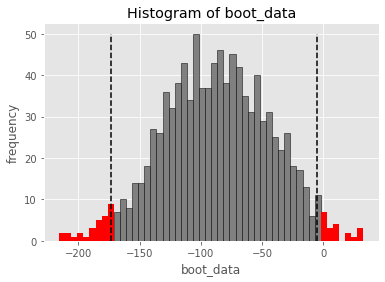

In [64]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [65]:
booted_data["p_value"] # альфа

0.04564731158962379

In [66]:
booted_data["quants"] # ДИ

,0
0.025,-173.270058
0.975,-4.865217


In [ ]:
#p-value<0.05 и 0 не попадает в доверительный интервал, поэтому нулевая гипотеза отклоняется, 
#то есть средние значения тестовой и контрольной группы отличаются значимо

для имеющихся данных не подходит t-test, так как распределение метрики в тестовой группе является ненормальным,
Манн-Уитни и bootstrap проверяют разные гипотезы, с помощью bootstrap мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений
в данном случае лучше всего подходит метод bootstrap, поэтому будем использовать выводы, полученные на его основе